In [1]:
import nilearn
from nilearn.plotting import plot_carpet, plot_glass_brain, plot_anat, plot_stat_map, plot_design_matrix, plot_epi, plot_contrast_matrix
from nilearn import image, masking, input_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.reporting import get_clusters_table, make_glm_report
from nilearn.input_data import NiftiLabelsMasker, NiftiMasker, NiftiSpheresMasker
from nilearn import datasets
from nilearn.regions import RegionExtractor
from nilearn import plotting
from nilearn import surface
from nilearn.decoding import Decoder

/home/vm01/anaconda3/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


## Extract fmri and mask files 

In [2]:
subject_id = '03'
fmri_image = list()
mask_image = list()
for run in range(1, 11):
    if run%2 == 0:
        task = 'rotate'
    else:
        task = 'straight'
    fmri_file = f"data/derivatives/sub-{subject_id}/func/sub-{subject_id}_task-{task}_run-{run}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
    fmri_image.append(fmri_file)
    mask_file = f"data/derivatives/sub-{subject_id}/func/sub-{subject_id}_task-{task}_run-{run}_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"
    mask_image.append(mask_file)


## Extract Events function

In [130]:
events_home_dir = '/home/vm01/Documents/fmri_project_copy/fmri_behavioral_data/'

def get_events_file(subject_id, run):
    events_file = events_home_dir + 'sub-' + subject_id  + '/run-' + str(run).zfill(2) + '/events.csv'
    #events_file = 'events_run_' + str(i) + '.csv'

    events = pd.read_csv(events_file)
    events = events.drop('Unnamed: 0', 1)
    
    #Uncomment below to collapse across go/nogo
    events['trial_type'] = events['trial_type'].replace({'nogo_45_prep':'45_prep', 
                                                 'nogo_99_prep':'99_prep',
                                                 'nogo_153_prep': '153_prep',
                                                 'nogo_207_prep':'207_prep',
                                                 'go_45_prep':'45_prep', 
                                                 'go_99_prep':'99_prep',
                                                 'go_153_prep': '153_prep',
                                                 'go_207_prep':'207_prep'                                                    

                                                })
    
    #Uncomment to do trial_wise events
    #events.loc[events.trial_type.str.contains('prep'), 'trial_type'] = events[events.trial_type.str.contains('prep')]['trial_type'].values + '_'+ np.arange(40).astype(str)

    
    #Uncomment to do odd-even events
    
    sorted_ev = events.sort_values(['trial_type', 'onset'])
    sorted_ev.loc[sorted_ev.trial_type.str.contains('prep'), 'trial_type'] = sorted_ev[sorted_ev.trial_type.str.contains('prep')].trial_type + '_' + np.tile(['odd', 'even'], 20)
    events = sorted_ev.sort_index()
    
    return events


In [131]:
events = get_events_file('02', 1)

## Fit glm function
Takes subject id and run number as parameters. 
Events are extracted by the extract events file

In [136]:
def fit_glm(subject_id, run):
    events = get_events_file(subject_id, run)
    tr = 1.25
    n_scans = image.load_img(fmri_image[run-1]).shape[-1]
    frame_times = np.arange(n_scans) * tr
    motion = np.cumsum(np.random.randn(n_scans, 6), 0)
    add_reg_names = ['tx', 'ty', 'tz', 'rx', 'ry', 'rz']

    design_matrix = make_first_level_design_matrix(frame_times, events, 
                                               drift_model='polynomial', drift_order=3, 
                                               add_regs=motion, add_reg_names=add_reg_names, 
                                               hrf_model='spm')
    
    fmri_glm_model = FirstLevelModel(t_r=1.25, minimize_memory=False, noise_model='ar1', mask_img=mask_image[run-1])
    fmri_glm_model.fit(fmri_image[run-1], design_matrices=design_matrix)
    print("run done: ", run)
    return fmri_glm_model, design_matrix


## Compute Contrast functions

In [137]:
def compute_no_diff_contrasts(glm, run):
    z_maps = list()
    conditions_label = list()
    sessions_label = list()
    events = get_events_file(subject_id, run)
    conditions = events.trial_type.unique()

    for condition_ in conditions:
        z_maps.append(glm[run-1].compute_contrast(condition_))
        conditions_label.append(condition_)
        sessions_label.append(str(run))
    return z_maps, conditions_label, sessions_label

def get_movement_minus_wait_contrasts(design_matrices, glms):
    z_map_movement_minus_wait = list()
    movement_minus_wait_labels = list()
    for run in range(1, 11):
        contrast_matrix = np.eye(design_matrices[run-1].shape[1])
        basic_contrasts = dict([(column, contrast_matrix[i])
                                for i, column in enumerate(design_matrices[run-1].columns)])        
        movement_contrasts = basic_contrasts['movement_153'] + basic_contrasts['movement_207'] + basic_contrasts['movement_45'] + basic_contrasts['movement_99'] - basic_contrasts['wait']

        z_map_movement_minus_wait.append(glms[run-1].compute_contrast(movement_contrasts))
        movement_minus_wait_labels.append('Movement minus wait, run_' + str(run).zfill(2))
    
    return z_map_movement_minus_wait, movement_minus_wait_labels

def get_prep_minus_wait_contrasts(design_matrices, glms):
    z_map_prep_minus_wait = list()
    prep_minus_wait_labels = list()
    for run in range(1, 11):
        contrast_matrix = np.eye(design_matrices[run-1].shape[1])
        basic_contrasts = dict([(column, contrast_matrix[i])
                                for i, column in enumerate(design_matrices[run-1].columns)])        
        movement_contrasts = basic_contrasts['go_153_prep'] + basic_contrasts['go_207_prep'] + basic_contrasts['go_45_prep'] + basic_contrasts['go_99_prep'] + basic_contrasts['nogo_153_prep'] + basic_contrasts['nogo_207_prep'] + basic_contrasts['nogo_45_prep'] + basic_contrasts['nogo_99_prep'] - basic_contrasts['wait']

        z_map_prep_minus_wait.append(glms[run-1].compute_contrast(movement_contrasts))
        prep_minus_wait_labels.append('Prep minus wait, run_' + str(run).zfill(2))
    
    return z_map_prep_minus_wait, prep_minus_wait_labels



## Plotting Contrasts functions

Takes z_maps, z_map_no, condition_label as arguments

Default arguments for "display_mode" is 'ortho, "correction" is 'bonferroni', "alpha" is '0.05'  

In [138]:
def plot_contrast_maps(z_maps, z_map_no, condition_label, display_mode = 'ortho', correction = 'bonferroni', alpha = 0.05):    
    _, threshold = threshold_stats_img(
        z_maps[z_map_no], alpha= alpha, height_control=correction)
    print('Bonferroni-corrected, p<0.05 threshold: %.3f' % threshold)

    plot_map = plot_stat_map(z_maps[z_map_no], threshold = threshold, 
                             black_bg=True, display_mode=display_mode, draw_cross=False,
                             title = condition_label[z_map_no] + ' '+ correction + ' corrected, p<0.05')
    #masker.fit(z_maps[z_map_no])
    #report = masker.generate_report()
    #plot_map.add_contours(image.index_img(atlas_filename, 11))
    plotting.show()
    return plot_map#, masker
    

In [139]:
def plot_surface_maps(z_maps, z_map_no, condition_label, correction = 'bonferroni', alpha = 0.05):

    _, threshold = threshold_stats_img(
    z_maps[z_map_no], alpha= alpha, height_control=correction)
    print('Bonferroni-corrected, p<0.05 threshold: %.3f' % threshold)

    texture = surface.vol_to_surf(z_maps[z_map_no], fsaverage.pial_left)
    parcellation = destrieux_atlas['map_left']
    regions_dict = {b'G_postcentral': 'Postcentral Gyrus', 
                    b'G_precentral': 'Precentral Gyrus',
                    b'G_pariet_inf-Angular': 'Angular Parietal Inf',
                    b'G_parietal_sup': 'Parietal Sup',
                   }
    regions_indices = [np.where(np.array(destrieux_atlas['labels']) == region)[0][0] for region in regions_dict]
    labels = list(regions_dict.values())
    
    figure = plotting.plot_surf_stat_map(fsaverage.infl_left, texture, hemi = 'left', 
                                        title = 'Surface left hemisphere', 
                                        colorbar = True, threshold = threshold, 
                                        bgmap = fsaverage.sulc_right)
    plotting.plot_surf_contours(fsaverage.infl_left, parcellation, labels = labels, 
                               levels = regions_indices, figure = figure, legend = True)
    plotting.show()

In [140]:
glms = list()
glm_labels = list()
design_matrices = list()
for run in range(1, 11):
    g, d = fit_glm(subject_id, run)
    glms.append(g)
    glm_labels.append(run)
    design_matrices.append(d)


/home/vm01/anaconda3/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:63: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


run done:  1


/home/vm01/anaconda3/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:63: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


run done:  2


/home/vm01/anaconda3/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:63: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


run done:  3


/home/vm01/anaconda3/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:63: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


run done:  4


/home/vm01/anaconda3/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:63: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


run done:  5


/home/vm01/anaconda3/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:63: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


run done:  6


/home/vm01/anaconda3/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:63: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


run done:  7


/home/vm01/anaconda3/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:63: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


run done:  8


/home/vm01/anaconda3/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:63: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


run done:  9


/home/vm01/anaconda3/lib/python3.8/site-packages/nilearn/glm/first_level/first_level.py:63: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


run done:  10


In [9]:
z, l, s = compute_no_diff_contrasts(glms, 2)

In [12]:
import os
for run in range(1, 11):
    run_no = str(run).zfill(2)
    if not os.path.exists(f'analyses_results/sub-{subject_id}/beta_maps/run-{run_no}'):
        os.mkdir(f'analyses_results/sub-{subject_id}/beta_maps/run-{run_no}')
    z, l, s = compute_no_diff_contrasts(glms, run)

    prep_45 = []
    prep_99 = []
    prep_153 = []
    prep_207 = []
    prep = {}

    for i in range(len(l)):
        if l[i].startswith('45'):
            prep_45.append(z[i])
        elif l[i].startswith('99'):
            prep_99.append(z[i])
        elif l[i].startswith('153'):
            prep_153.append(z[i])
        elif l[i].startswith('207'):
            prep_207.append(z[i])

    prep['45'] = image.concat_imgs(prep_45)
    prep['99'] = image.concat_imgs(prep_99)
    prep['153'] = image.concat_imgs(prep_153)
    prep['207'] = image.concat_imgs(prep_207)
    
    for i in prep.keys():
        prep[i].to_filename(f"analyses_results/sub-{subject_id}/beta_maps/run-{run_no}/prep_{i}.nii.gz")
    
    print("Run done: ", run)

Run done:  1
Run done:  2
Run done:  3
Run done:  4
Run done:  5
Run done:  6
Run done:  7
Run done:  8
Run done:  9
Run done:  10


Bonferroni-corrected, p<0.05 threshold: 3.752


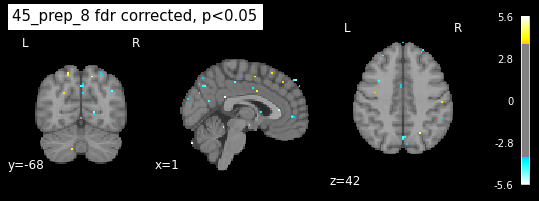

In [17]:
plot_contrast_maps(z, 9, l, correction='fdr')

In [61]:
np.ravel(np.vstack((np.floor(prep_events['onset']/1.25).astype(int).values, np.floor(prep_events['onset']/1.25).astype(int).values+1)), order='F')

array([  9,  10,  17,  18,  25,  26,  30,  31,  36,  37,  43,  44,  51,
        52,  58,  59,  67,  68,  79,  80,  86,  87,  93,  94, 106, 107,
       112, 113, 120, 121, 128, 129, 135, 136, 147, 148, 155, 156, 161,
       162, 167, 168, 173, 174, 181, 182, 188, 189, 200, 201, 207, 208,
       219, 220, 225, 226, 233, 234, 240, 241, 252, 253, 258, 259, 271,
       272, 278, 279, 284, 285, 292, 293, 300, 301, 308, 309, 314, 315,
       320, 321])

In [183]:
events = get_events_file('02', 1)

In [184]:
prep_events = events[events['trial_type'].str.contains('prep')].reset_index().drop('index', 1)

In [185]:
prep_events['target_location'] = '207'
prep_events.loc[prep_events['trial_type'].str.contains('45'), 'target_location'] = '45'
prep_events.loc[prep_events['trial_type'].str.contains('99'), 'target_location'] = '99'
prep_events.loc[prep_events['trial_type'].str.contains('153'), 'target_location'] = '153'


In [186]:
prep_events = prep_events.drop('trial_type', 1)

In [187]:
prep_events = prep_events.sort_values(by='onset')

In [188]:
indices = np.floor(prep_events['onset']/1.25).astype(int).values

In [189]:
prep_images = image.index_img(fmri_image[0], np.ravel(np.vstack((indices, indices+1)), order = 'F'))

In [190]:
nifti_masker = NiftiMasker(standardize=True, mask_strategy='whole-brain-template')
nifti_masker.fit(prep_images)
mask_img = nifti_masker.mask_img_

In [191]:
nifti_masker.fit(prep_images)
fmri_masked = nifti_masker.transform(prep_images)

In [192]:
fmri_masked.shape

(80, 111559)

In [193]:
conditions = prep_events.target_location.values 

In [203]:
decoder = Decoder(estimator='svc_l1', mask = nifti_masker)
decoder.fit(prep_images, np.repeat(conditions, 2))
dummy_decoder = Decoder(estimator='dummy_classifier', mask = nifti_masker)
dummy_decoder.fit(prep_images, np.repeat(conditions, 2))

/home/vm01/anaconda3/lib/python3.8/site-packages/nilearn/input_data/masker_validation.py:97: UserWarning: Overriding provided-default estimator parameters with provided masker parameters :
Parameter mask_strategy :
    Masker parameter whole-brain-template - overriding estimator parameter background

  warnings.warn(warn_str)
/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  1115   4058   4059 ... 109827 110539 111423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  1115   4058   4059 ... 109827 110539 111423] are constant.
  warnings.warn("Features %s are constant." % c

/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  1115   4058   4059 ... 109827 110539 111423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  1115   4058   4059 ... 109827 110539 111423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [

/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  1115   4058   4059 ... 109827 110539 111423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [  1115   4058   4059 ... 109827 110539 111423] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/home/vm01/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


KeyboardInterrupt: 

In [148]:
rotation_wb_decoding_accuracies = {'153': np.mean(decoder.cv_scores_['153']), 
                                   '207': np.mean(decoder.cv_scores_['207']),
                                   '99': np.mean(decoder.cv_scores_['99']), 
                                   '45': np.mean(decoder.cv_scores_['45'])
                                  }

In [196]:
straight_wb_decoding_accuracies = {'153': np.mean(decoder.cv_scores_['153']), 
                                   '207': np.mean(decoder.cv_scores_['207']),
                                   '99': np.mean(decoder.cv_scores_['99']), 
                                   '45': np.mean(decoder.cv_scores_['45'])
                                  }

In [198]:
straight_wb_decoding_accuracies, 

({'153': 0.8166666666666667,
  '207': 0.9916666666666666,
  '99': 0.8333333333333334,
  '45': 0.8583333333333334},
 {'153': 0.45, '207': 0.525, '99': 0.55, '45': 0.5083333333333334})

In [199]:
rotation_wb_decoding_accuracies

{'153': 0.45, '207': 0.525, '99': 0.55, '45': 0.5083333333333334}

In [ ]:
mean_null_cv = np.mean(null_cv_scores, axis = 1)

In [ ]:
rotate_percent_above_chance = (mean_cv/mean_null_cv)*100

In [ ]:
rotate_percent_above_chance - 100

In [ ]:
decoding_accuracy = pd.DataFrame({'Regions': masker.labels[1:],                              
                                  'straight_perc_above_chance': percent_above_chance,
                                  'rotate_perc_above_chance': rotate_percent_above_chance
                                 })

In [ ]:
decoding_accuracy.to_html('decoding_accuracies.html')

In [201]:
rotation_wb_decoding_accuracies

{'153': 0.45, '207': 0.525, '99': 0.55, '45': 0.5083333333333334}

In [202]:
rotate_da = pd.DataFrame.from_dict(rotation_wb_decoding_accuracies)

ValueError: If using all scalar values, you must pass an index